# Import template 

In [1]:
%%capture
import math
import numpy as np
# from matplotlib.pyplot import *
import matplotlib.pyplot as plt
# import seaborn as sns
import scipy.io.wavfile as wave
import glob as glob
import pandas as pd
import os
import os.path
import time
from IPython.display import clear_output
from numpy.fft import fft
import librosa
from IPython.display import Audio
from ipywidgets import interactive
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D,Conv2D, LeakyReLU, Flatten, GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, ReLU, Flatten
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model  import RidgeCV,LassoCV 
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'
os.environ['LIBROSA_CACHE_LEVEL']='20'

from tqdm import tqdm # code pour afficher une barre de chargement il faut installer la librairie tqdm pour qu'il marche



In [ ]:
def augmentation_noise(numpy, coef= 0,009):
    augmented_sound = numpy + coef*np.ramdom.normal(0,1,len(numpy))
    return augmented_sound

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
isCollab = False
pathLogMel = "npy/"
pathDriveSaveFile = "models_save/"

if isCollab:
    pathLogMel = "/content/drive/MyDrive/Datascience projet son/LogMel/"
    pathDriveSaveFile = "/content/drive/MyDrive/Datascience projet son/You/Auto_save_AE_"

### FONCTIONS

In [3]:
#sauvegarde d'un modèle
# model_bin.save('modele_bin_slider_coco.joblib')

#boucle d'enregistrement des spectres 
def enregistrement_npy(dt=256):
  for machine in df.Machine.unique():
      #Génération de spectres
      df_train = df[ (df['Machine']== machine) & (df['train_test'] == 'train') ] # sélection de la machine 
      df_valid = df[ (df['Machine']== machine) & (df['train_test'] == 'test') ] # sélection de la machine 

      #partie non testée pour adapter l'URL au google drive
      URLS_train=[]
      URLS_valid=[]
      for lignes in df_train['URL']:
        URLS_train.append(str("/content/drive/MyDrive/Datascience projet son/"+lignes))
      for lignes in df_valid['URL']:
        URLS_valid.append(str("/content/drive/MyDrive/Datascience projet son/"+lignes))

      data_train = load_data(URLS_train, dt=dt, T_max=10,normalize=True)
      data_valid = load_data(URLS_valid, dt=dt, T_max=10,normalize=True)
      
      # on cherche la puissance de 2 la plus proche du nb fréquence
      carre=2
      while carre<data_train.shape[2]:
          carre*=2
      
      freq=int(carre/2)
      
      #Reduction de dimension
      sel=downsizing()      
      sel.fit(data_train,seuil_db=False,nb_freq=freq)
      data_train=sel.transform(data_train,normalize=False)
      data_valid=sel.transform(data_valid,normalize=False)

      #Enregistrement
      nom_fichier_train=str(str(machine)+"_train_norm_"+str(dt)+"_"+str(freq)+".npy")
      nom_fichier_test=str(str(machine)+"_test_norm_"+str(dt)+"_"+str(freq)+".npy")

      np.save(nom_fichier_train,data_train.flatten())
      np.save(nom_fichier_test,data_valid.flatten())
  return

#chargement des données en entrée
def load_data(audio_path, dt=0.5, T_max=10, normalize=False):
    """
    Permet de charger un spectre logmel depuis un path. 
    
    params: 
    
    dt: float /int. si [0:1[ alors dt est considéré comme un pas de découpage en seconde 
        si >=1 alors doit être un int réprésentant le nombre de découpages souhaité
    
    """
    X_audio=[]
    
    if dt<1: # on veut selectionner le pas en seconde
        with tqdm(total=len(audio_path)) as pbar: # code pour afficher une barre de chargement
            for i, a_path in enumerate(audio_path) :
                pbar.update(1) # permet de mettre la barre de chargement à jour en ajoutant 1 itération
                # Load the audio file
                data, fe = librosa.load(a_path, sr=None)

                # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
                if len(data)>= T_max*fe:
                    data = data[:int(T_max*fe)]

                # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
                else :
                    data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

                # Apply the logMelSpectrogram function.    
                spectre_audio = logMelSpectrogram(data, fe, dt)
                if normalize : 
                    spectre_audio=(np.array(spectre_audio)-np.array(spectre_audio).min())/(np.array(spectre_audio).max()-np.array(spectre_audio).min())
                    X_audio.append(spectre_audio)
            
        
    else: # on veut selectionner un nombre de dt 
        with tqdm(total=len(audio_path)) as pbar:
            for a_path in audio_path :
                pbar.update(1)
                # Load the audio file
                data, fe = librosa.load(a_path, sr=None)

                # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
                if len(data)>= T_max*fe:
                    data = data[:int(T_max*fe)]

                # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
                else :
                    data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

                # Apply the logMelSpectrogram function. 

                spectre_audio = logMelSpectrogram(data[:(len(data)//dt)*dt], fe, np.around(T_max/dt,3))
                spectre_audio=spectre_audio[:dt,:] # on tronque quand même au cas où nous avons dépasser le nombre de dt. 
                if normalize : 
                    spectre_audio=(np.array(spectre_audio)-np.array(spectre_audio).min())/(np.array(spectre_audio).max()-np.array(spectre_audio).min())

                X_audio.append(spectre_audio)
                if np.array(X_audio).shape[1]!=dt:
                  raise Exception("Erreur le nombre de dt réalisé ne coincide pas avec la demande, changer le nombre demandé \n" "format actuel de sortie",np.array(X_audio).shape)
    
        return np.array(X_audio)

#Générateur de spectre
class spectrum_generator():
    def __init__(self):
        self.level=0
        self.v_translate=0
        self.cut=None
        self.nb_freq=0
        self.nb_dt=0
        self.nb_samples_tot=0
        self.nb_samples_target=0
        
    def fit(self,X,y,level=0,v_translate=0,dt_cut=None):
        #récupération des paramètres
        self.level=level
        self.v_translate=v_translate
        self.nb_samples_tot,self.nb_dt,self.nb_freq=X.shape
        
        if dt_cut=='first':
            self.cut=0
        elif dt_cut=='last':
            self.cut=-1
        elif dt_cut=='both':  
            self.cut=[0,-1]
        else :
            self.cut=None
        
    def flow_from_numpy(self,X,y,batchsize=32,pourcent_modif=0.1):
        #initialisation de la selection aléatoire des samples
        selector=np.random.random(batchsize)*self.nb_samples_tot
        selector=selector.astype(int)
        transform_sel=np.random.random(int(pourcent_modif*batchsize))*selector.shape
        transform_sel=transform_sel.astype(int)
        #sélection des samples
        X_selected=np.array(X)[selector]
        y_selected=np.array(y)[selector]
        #transformation aléatoire des samples via une des fonctions
        for modif in transform_sel:
            choix_modif=int(np.random.random(1)*3)
            if choix_modif<=1:
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1+(self.level*np.random.random(1))-(self.level*np.random.random(1))) # on multiplie le spectre par une valeur 1+- self.level
           
            elif (choix_modif>1) and (choix_modif<=2):
                X_selected[modif,:,:]=X_selected[modif,:,:]+(self.v_translate*np.random.random(1))-(self.v_translate*np.random.random(1))# on ajoute au spectre une valeur 1+- self.v_translate
            
            elif (choix_modif>2) and (choix_modif<=3):
                for dt in self.cut:
                    X_selected[modif,dt,:]=X_selected[modif,dt,:]*0
            else:
                X_selected[modif,:,:]=X_selected[modif,:,:]
        
        return X_selected,y_selected
        
    def add_samples(self,X,y,pourcent_add=0.1, labels='all', inplace=True):
        self.nb_samples_tot=y.shape[0]
        if labels=='all':
            self.nb_samples_target=self.nb_samples_tot
        else:
            self.nb_samples_target=y[y==labels].shape[0]
        
        if self.nb_samples_target ==self.nb_samples_tot : 
            #initialisation de la selection aléatoire des samples
            selector=np.random.random(int(pourcent_add*self.nb_samples_tot))*self.nb_samples_tot
            selector=selector.astype(int)
            #sélection des samples
            X_selected=np.array(X)[selector]
            y_selected=np.array(y)[selector]
        
        else :
            selector=np.random.random(int(pourcent_add*self.nb_samples_target))*self.nb_samples_target
            selector=selector.astype(int)
            #sélection des samples
            X_selected=np.array(X)[y==labels][selector]
            y_selected=np.array(y)[y==labels][selector]
        
        #transformation aléatoire des samples via une des fonctions
        for modif in range(X_selected.shape[0]):
            choix_modif=int(np.random.random(1)*3)
            if choix_modif<=1:
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1+self.level)
           
            elif (choix_modif>1) and (choix_modif<=2):
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1-self.level)  
            
            elif (choix_modif>2) and (choix_modif<=3):
                for dt in self.cut:
                    X_selected[modif,dt,:]=X_selected[modif,dt,:]*0
            else:
                X_selected[modif,:,:]=X_selected[modif,:,:]
        
        if inplace : 
          return np.concatenate((X,X_selected),axis=0),np.concatenate((y,y_selected),axis=0)   
        else : 
          return X_selected,y_selected 

#création du masque
class downsizing():
    def __init__(self):
        self.selector=0
        self.datamax=0
    
    def fit(self,X,seuil_db=False,nb_freq=False):
        self.datamax=X.max(axis=1).max(axis=0)
        if (seuil_db!=False) and (nb_freq!=False):
                return print('Renseignez un seuil_db OU un nombre de fréquences à garder mais pas les deux')

        elif seuil_db=='brute':
            #Méthode brute
            data_s=X.sum(axis=1).sum(axis=0)
            data_s.shape
            self.selector=np.where(data_s>0,True,False)  
        elif seuil_db!=False:  
            self.selector=np.where(self.datamax>seuil_db,True,False)

        elif nb_freq!=False:  
            self.selector=np.where(self.datamax>np.sort(self.datamax)[-(nb_freq+1)],True,False) # on est très restrictif dans un premier temps 

            if np.sum(self.selector)<nb_freq:
                self.selector=np.where(self.datamax>=np.sort(self.datamax)[-(nb_freq+1)],True,False) # si nous avons été trop restrictif, alors nous élargissons la selection puis nous bouclons pour supprimer le surplus

            iter=100
            while np.sum(self.selector)>nb_freq and iter>0: # En cas de multiples valeurs similaires on boucle pour les supprimer et ne garder que la dim voulue
                print('Trop de fréquences choisies, suppression de {:} fréquences pour atteindre la taille cible'.format( self.selector.sum()-nb_freq))
                self.selector[np.argsort(np.sort(self.datamax[self.selector]))[-1]]=False  # on récupère la position du plus petit élément de datamax pour la supprimer du sélector
                iter-=1 # on met 10 itérations pour éviter de boucler à l'infini en cas d'erreur
        print('nombre de fréquences gardées: ', self.selector.sum())
        
    def transform(self,X,normalize=False):
        
        if normalize:
            def normalisation(ligne2D):
                return (np.array(ligne2D)-np.array(ligne2D).min())/(np.array(ligne2D).max()-np.array(ligne2D).min())  
            
            X_select=X[:,:,self.selector]
            X_select=np.array([ normalisation(samples) for samples in X_select ])
            return X_select
        
        else :
            return X[:,:,self.selector]
    
    
    def get_selector(self,seuil_db):
        self.selector=np.where(self.datamax>seuil_db,True,False)
        return self.selector
    
    
    def get_datamax(self):
        return self.datamax

    
def logMelSpectrogram(audio, fe, dt):
    stfts = np.abs(librosa.stft(audio,n_fft = int(dt*fe),hop_length = int(dt*fe),center = True)).T
    num_spectrogram_bins = stfts.shape[-1]
    # MEL filter
    linear_to_mel_weight_matrix = librosa.filters.mel(sr=fe,n_fft=int(dt*fe) + 1,n_mels=num_spectrogram_bins,).T
    # Apply the filter to the spectrogram
    mel_spectrograms = np.tensordot(stfts,linear_to_mel_weight_matrix,1)
    return np.log(mel_spectrograms + 1e-6)

def plot_logMelSpectrogram(audio, fe, dt=0.025):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, fe, dt)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    

    
# permet de lire et de récupérer les données d'un fichier wav
def wave_path(machine,folder,type_audio,k):
    machine_path='./'+machine+'/'
    type_path=folder+'/'
    zeros='00000000'+str(k)
    file_name=type_audio+'_id_00_'+zeros[-8:]+'.wav'
    file_path=machine_path+type_path+file_name
    rate,data = wave.read(file_path)
    graph_name=file_name.split('.')[0]+'_spectre.jpg'
    save_path=machine_path+'Spectres/'+graph_name
    n = data.size
    duree = 1.0*n/rate
    return file_path,save_path,n,duree,rate,data

# permet de faire la transformée de Fourier et de tracer le spectre d'un signal
def tracerSpectre_op(data,rate,debut,duree):
    start = int(debut*rate)
    stop = int((debut+duree)*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    # On crée les labels des abscices 
    n = spectre.size
    freq=np.linspace(1/n,1,n)*rate
    # On trace un barplot avec x=freq,y=spectre
    plt.vlines(freq,[0],spectre,'r')
    plt.xlabel('f (Hz)')
    plt.ylabel('A')
    plt.axis([0,0.5*rate,0,1])
    plt.grid()
    
#permet de faire la transformée de fourrier sur le signal
def Fourier(data,rate,debut,duree):
    start = int(debut*rate)
    stop = int((debut+duree)*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    # On crée les labels des abscices 
    n = spectre.size
    freq=np.linspace(1/n,1,n)*rate
    return freq,spectre

#permet de faire la transformée de fourrier sur le signal
def Frequences(data,rate):
    n = data.size
    duree = 1.0*n/rate
    start = int(0)
    stop = int(duree*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    return spectre

  #Algorythme de parcours de fichier
def Dossier_data(DOSSIER):
    """
    Cette fonction permet de parcourir les fichiers contenu 
    dans le DOSSIER 'DOSSIER' QUE VOUS SOUHAITEZ du notebook d'en extraire
    les informations et de générer un PandaDataFrame
    """
    if DOSSIER!='':
        chemin=glob.glob(''+DOSSIER+'/**',recursive=True)
    else :
        chemin=glob.glob('/**',recursive=True)
    
    df=pd.DataFrame(chemin, columns=['URL'])
    df['URL2']=df['URL'].apply(lambda contenu: os.path.split(contenu)[0])
    df['fichier']=df['URL'].apply(lambda contenu: os.path.split(contenu)[1])
    df['train_test']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[1])
    df['URL2']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[0])
    df['Machine']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[1])
    df=df[(df['Machine']!='')&(df['Machine']!='.')&(df['Machine']!='Datascience_projet_son')&(df['Machine']!='./archive')&(df['URL2']!='./archive')]
    df['Machine_ID']=df['fichier'].apply(lambda contenu: contenu.split('_')[2])
    df['son_type']=df['fichier'].apply(lambda contenu: contenu.split('_')[0])
    df=df.drop('URL2',axis=1)
    duree=[]
    nb_boucles=df.shape[0]
    tps1 = time.time()
    for i,URL in enumerate(df['URL']):
      tps2 = time.time()
      print('boucle: ',i+1 ,' / ', nb_boucles+1)
      print('temps écoulé:{:.2f} sec'.format(tps2 - tps1))
      print('temps restant:{:.0f} min'.format((tps2 - tps1)*(nb_boucles-i)/((i+1)*60)))
      duree.append(duration(URL))
      clear_output()
      if i%1000==0 : # on supprime le cache de la RAM toutes les 1000 itérations
        librosa.cache.clear()

    df['duree_son']=duree
    tps3 = time.time()
    print('temps total:',tps3 - tps1)
    return df




#Création du CSV
# df.to_csv('Fichiers_son.csv')
#Changement de l'ordre
# df=df.reindex(columns=['URL','fichier','fichier_type','Machine','Machine_ID','son_type','rate','spectre'])


# Definition Path Fichier & Variable

In [4]:
#chargement des modèles pré-entrainés
# autoencoder3D = keras.models.load_model("autoencoder3D_0506_fan_256dt_600E.joblib")
# autoencoderV2=keras.models.load_model("AE_V2.joblib")
# AE_DENSE_JAP=keras.models.load_model("AE_DENSE_JAP_427_320.joblib")
# AE_slider=keras.models.load_model("Auto_save_AE_slider.hdf5")

In [6]:
# IMPORT DES FICHIERS

dt=256
freq=256
normal_val=0
anomaly_val=1
coef_anorm=0.2


machine='ToyConveyor'
df=pd.read_csv('Fichiers_output_Projet/Fichiers_son.csv')
df.head()

,Unnamed: 0,URL,fichier,train_test,Machine,Machine_ID,son_type,duree_son
0,3,archive/ToyCar/test/normal_id_02_00000055.wav,normal_id_02_00000055.wav,test,ToyCar,2,normal,11.0
1,4,archive/ToyCar/test/normal_id_02_00000064.wav,normal_id_02_00000064.wav,test,ToyCar,2,normal,11.0
2,5,archive/ToyCar/test/normal_id_02_00000031.wav,normal_id_02_00000031.wav,test,ToyCar,2,normal,11.0
3,6,archive/ToyCar/test/normal_id_02_00000027.wav,normal_id_02_00000027.wav,test,ToyCar,2,normal,11.0
4,7,archive/ToyCar/test/normal_id_02_00000024.wav,normal_id_02_00000024.wav,test,ToyCar,2,normal,11.0


In [7]:
#Sélection des données
df_machine = df[ df['Machine']== machine ] # sélection de la machine 
df_machine_train = df_machine[df_machine['train_test'] == 'train'] # sélection du dataset train
df_machine_test = df_machine[df_machine['train_test'] == 'test']

y_train_ID = np.array(df_machine_train['Machine_ID'])
y_test_ID = np.array(df_machine_test['Machine_ID'])
y_test_son = np.array(df_machine_test['son_type'])

y_train_ID_dum=pd.get_dummies(y_train_ID,prefix='ID')
y_test_ID_dum=pd.get_dummies(y_test_ID,prefix='ID')

In [8]:
#Load data from prefromated npy files
#liens chargement enregistrement 
path_train = pathLogMel+machine+'_train_norm_'+str(dt)+'_'+str(freq)+'.npy' 
path_test = pathLogMel+machine+'_test_norm_'+str(dt)+'_'+str(freq)+'.npy'
#importation des fichiers npy
X_train = np.load(path_train)
X_test = np.load(path_test)

#reshaping
X_train = X_train.reshape(-1,dt,freq)
X_test = X_test.reshape(-1,dt,freq)

generator=spectrum_generator()
generator.fit(X_train,y_train_ID,level=0.1,v_translate=0.1,dt_cut=False)
X_gen,y_gen=generator.add_samples(X_train,y_train_ID,pourcent_add=0.5, labels='all',inplace=False)

In [9]:
# On ajoute une mention pour les données générées
y_gen_ID_dum=pd.get_dummies(y_gen)
y_gen_ID_dum=y_gen_ID_dum*(1-coef_anorm)
ajout=np.ones(y_gen_ID_dum.shape[0])*coef_anorm
y_gen_ID_dum=pd.concat([y_gen_ID_dum,pd.DataFrame(ajout,columns=['Anomaly'])],axis=1)


#Idem pour les données initiales
ajout=np.zeros(y_train_ID_dum.shape[0])
y_train_ID_dum=pd.concat([y_train_ID_dum,pd.DataFrame(ajout,columns=['Anomaly'])],axis=1)

#On rassemble les données
y_gen_ID_dum.columns = y_train_ID_dum.columns
y_train_ID_dum=pd.concat([y_train_ID_dum,y_gen_ID_dum],axis=0)
X_train=np.concatenate((X_train,X_gen),axis=0)

#on fait pareil pour le test 
y_norm=np.where(y_test_son=='normal',normal_val,anomaly_val)
ajout=np.ones(y_test_ID_dum.shape[0])*y_norm*coef_anorm
y_test_ID_dum=pd.concat([y_test_ID_dum,pd.DataFrame(ajout,columns=['Anomaly'])],axis=1)
y_test_ID_dum[y_test_ID_dum.Anomaly>0]=y_test_ID_dum[y_test_ID_dum.Anomaly>0]*(1-coef_anorm)

# CLASSIFICATION RNN

In [26]:
#Modèle GRU + batch -AE
#Modèle rapide et fonctionnel sur Slider


from keras.layers import Dense, BatchNormalization,Activation,Reshape

nb_classe = y_train_ID_dum.shape[1]

#on ajoute l'ancien modèle
Classificateur_GRU64 = Sequential()

Classificateur_GRU64.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(256,256)))
Classificateur_GRU64.add(tf.keras.layers.BatchNormalization())
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(tf.keras.layers.GRU(64))
Classificateur_GRU64.add(tf.keras.layers.BatchNormalization())
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(Dense(64))
Classificateur_GRU64.add(Dropout(0.2))
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(Dense(nb_classe, activation='softmax'))
Classificateur_GRU64.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 256, 64)           61824     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 64)           256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256, 64)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
#Modèle GRU + batch -AE
#Modèle plus poussé long au calcul (200s / EPOCH)


nb_classe = y_train_ID_dum.shape[1]

Classificateur_GRU64 = Sequential()

Classificateur_GRU64.add(tf.keras.layers.GRU(64, input_shape=(256,256), return_sequences=True,recurrent_dropout=0.2))
Classificateur_GRU64.add(tf.keras.layers.BatchNormalization())
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(tf.keras.layers.GRU(64))
Classificateur_GRU64.add(tf.keras.layers.BatchNormalization())
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(Dense(64))
Classificateur_GRU64.add(Dropout(0.2))
Classificateur_GRU64.add(LeakyReLU())

Classificateur_GRU64.add(Dense(nb_classe, activation='softmax'))
Classificateur_GRU64.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256, 64)           61824     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64)           256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [27]:
EPOCHS=50
BATCH=64
from keras.callbacks import ModelCheckpoint
#chemin d'enregistrement de l'autosave AUTO ENCODER
autosave_path='Auto_save_Class_GRU.hdf5'

Classificateur_GRU64.compile(loss = 'categorical_crossentropy', optimizer = 'adagrad', metrics = ['accuracy'])

checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=5)
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, mode='min',restore_best_weights=True)

history_Classificateur_GRU64 = Classificateur_GRU64.fit(X_train, y_train_ID_dum, validation_split=0.2,
                                       verbose=1, batch_size=BATCH, epochs=EPOCHS,shuffle=True,
                                       callbacks = [checkpoint],max_queue_size=30,
                                       workers=4,use_multiprocessing=True)

Epoch 1/50
57/57 [==============================] - 11s 138ms/step - loss: 1.2015 - accuracy: 0.4582 - val_loss: 1.3607 - val_accuracy: 0.3511
Epoch 2/50
57/57 [==============================] - 7s 125ms/step - loss: 0.6869 - accuracy: 0.8369 - val_loss: 1.3235 - val_accuracy: 0.6622
Epoch 3/50
57/57 [==============================] - 7s 125ms/step - loss: 0.4834 - accuracy: 0.9303 - val_loss: 1.2729 - val_accuracy: 0.8267
Epoch 4/50
57/57 [==============================] - 7s 124ms/step - loss: 0.3730 - accuracy: 0.9632 - val_loss: 1.1959 - val_accuracy: 0.8822
Epoch 5/50
57/57 [==============================] - 7s 124ms/step - loss: 0.3234 - accuracy: 0.9729 - val_loss: 1.0932 - val_accuracy: 0.9722

Epoch 00005: val_loss improved from inf to 1.09320, saving model to Auto_save_Class_GRU.hdf5
Epoch 6/50
57/57 [==============================] - 7s 126ms/step - loss: 0.2837 - accuracy: 0.9834 - val_loss: 0.9975 - val_accuracy: 0.9611
Epoch 7/50
57/57 [==============================] - 7

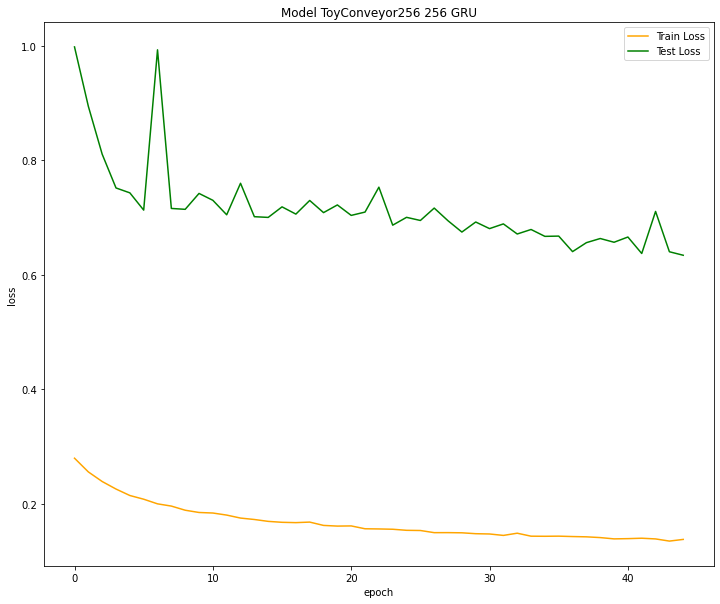

In [28]:
#plot de l'entrainement
plt.figure(figsize=(12,10))
plt.plot(history_Classificateur_GRU64.history['loss'][5:],'orange' ,label = 'Train Loss',)
plt.plot(history_Classificateur_GRU64.history['val_loss'][5:],'g', label = 'Test Loss')
plt.title('Model ' + machine+ str(dt) +" " + str(freq) +' GRU')
# plt.ylim((0,2))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

In [68]:
Classificateur_GRU64.save('/content/drive/MyDrive/Datascience projet son/Corentin/Classificateur_GRU64_ToyConveyor_5N.joblib')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datascience projet son/Corentin/Classificateur_GRU64_ToyConveyor_5N.joblib/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datascience projet son/Corentin/Classificateur_GRU64_ToyConveyor_5N.joblib/assets


# Affichage des resultats

In [10]:
Classificateur_GRU64=keras.models.load_model("Classificateur_GRU64_ToyConveyor_5N.joblib")
y_pred_train=Classificateur_GRU64.predict(X_train)
y_pred_train_anomaly=y_pred_train[:,y_pred_train.shape[1]-1]
y_pred_train_anomaly_save=y_pred_train_anomaly

NotImplementedError: Cannot convert a symbolic Tensor (gru_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [14]:
y_pred_train_anomaly_save

array([0.00436514, 0.00998846, 0.00131347, ..., 0.4050663 , 0.18313289,
       0.03457445], dtype=float32)

In [16]:
#prédictions sur le train 
#attention la ré-execution de la cellule peut générer des problèmes dans ce cas reloader les différentes variable y



y_qualif_OK=y_pred_train[y_train_ID_dum.Anomaly==0] # Vecteur servant pour obtenir la densité sur le train ORGINAL uniquement
y_qualif_MODIF=y_pred_train[y_train_ID_dum.Anomaly!=0] # Vecteur servant pour obtenir la densité sur le train MODIFIE uniquement

y_train_multi=y_train_ID_dum.replace([1-coef_anorm,coef_anorm],[1,1]) #On créé une matrice catégorielle pour la comparaison

y_pred_train[y_train_multi.Anomaly==0]=y_pred_train[y_train_multi.Anomaly==0]*y_train_multi[y_train_multi.Anomaly==0] #On scinde le vecteur de résultat et on met à jour les prédictions selon le type de son
y_pred_train[y_train_multi.Anomaly>0]=y_pred_train[y_train_multi.Anomaly>0]*y_train_multi[y_train_multi.Anomaly>0]
y_pred_train=pd.DataFrame(y_pred_train)
y_pred_train.columns=y_train_multi.columns

# #création du dataframe pour les graphiques
data_graph=y_train_ID_dum #on récupère la structure de train ID
data_graph.iloc[:,:y_pred_train.shape[1]-1]=y_pred_train.iloc[:,:y_pred_train.shape[1]-1] # on met les valeurs des prédictions
data_graph["predictions"]=y_pred_train_anomaly
data_graph["Anomaly"]=data_graph["Anomaly"].replace([0,coef_anorm],['original','modifié'])


#et le test
y_pred_test = Classificateur_GRU64.predict(X_test)
y_pred_ID_test = y_pred_test.argmax(axis=1)



In [17]:
y_pred_train_anomaly_save

array([0.        , 0.        , 0.        , ..., 0.4050663 , 0.18313289,
       0.03457445], dtype=float32)

2399 erreurs sur la classe normal soit 100.00 %  
1109 erreurs sur la classe anomaly soit 99.91 %  
détails fichiers normaux
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     800.0
           2       0.00      0.00      0.00     800.0
           3       0.00      0.00      0.00     799.0

    accuracy                           0.00    2399.0
   macro avg       0.00      0.00      0.00    2399.0
weighted avg       0.00      0.00      0.00    2399.0

détails fichiers anomaly
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       355
           3       0.00      0.00      0.00       355

    accuracy                           0.00      1110
   macro avg       0.00      0.00      0.00      1110
weighted avg       0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

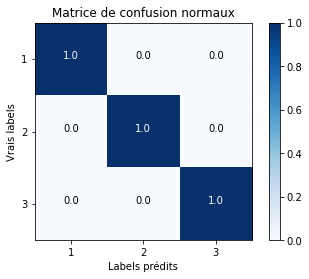

<Figure size 720x720 with 0 Axes>

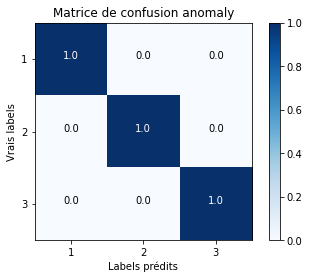

In [30]:
import itertools
err_normal = 0
err_anomaly = 0
for i in range(len(y_test_ID)):
    if (y_pred_ID_test[i] != y_test_ID[i]):
        if y_test_son[i] == 'normal':
           err_normal += 1  
        else:
           err_anomaly += 1
        
#print('nombre erreurs total: ', nbr_erreurs_total)
print('{} erreurs sur la classe normal soit {:.2f} %  '.format(err_normal, 100*err_normal/y_test_son[y_test_son=='normal'].shape[0]))
print('{} erreurs sur la classe anomaly soit {:.2f} %  '.format(err_anomaly, 100*err_anomaly/y_test_son[y_test_son=='anomaly'].shape[0]))

#résultats sur les fichiers normaux
print('détails fichiers normaux')
print(metrics.classification_report(y_test_ID[y_test_son=='normal'], y_pred_ID_test[y_test_son=='normal']))
crosstab=pd.crosstab(y_test_ID[y_test_son=='normal'], y_pred_ID_test[y_test_son=='normal'], rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion normaux")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train_ID)))
plt.xticks(tick_marks, np.unique(y_train_ID))
plt.yticks(tick_marks, np.unique(y_train_ID))

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(crosstab.iloc[i, j],2),
             horizontalalignment="center",
             color="white" if crosstab.iloc[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')


#résultats sur les fichiers anomaly
print('détails fichiers anomaly')
print(metrics.classification_report(y_test_ID[y_test_son=='anomaly'], y_pred_ID_test[y_test_son=='anomaly']))
crosstab=pd.crosstab(y_test_ID[y_test_son=='anomaly'], y_pred_ID_test[y_test_son=='anomaly'], rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')
plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion anomaly")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train_ID)))
plt.xticks(tick_marks, np.unique(y_train_ID))
plt.yticks(tick_marks, np.unique(y_train_ID))

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(crosstab.iloc[i, j],2),
             horizontalalignment="center",
             color="white" if crosstab.iloc[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');


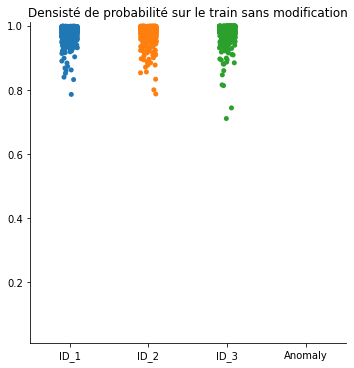

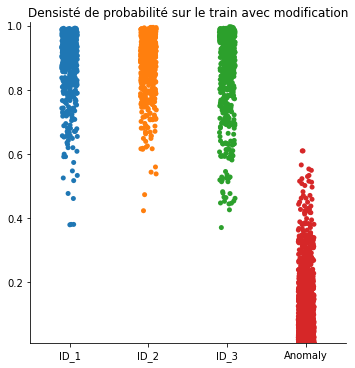

In [31]:
#Réalisation des densités de probabilité sur le train 
sns.catplot(data=y_pred_train[y_pred_train.Anomaly==0])
plt.title("Densisté de probabilité sur le train sans modification")
plt.ylim((0.01,1.01));
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Predic_train_norm'+machine+'.jpg' )

sns.catplot(data=y_pred_train[y_pred_train.Anomaly>0])
plt.title("Densisté de probabilité sur le train avec modification")
plt.ylim((0.01,1.01));
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Predic_train_anorm'+machine+'.jpg' )

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

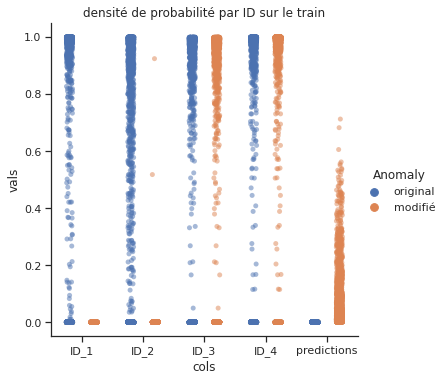

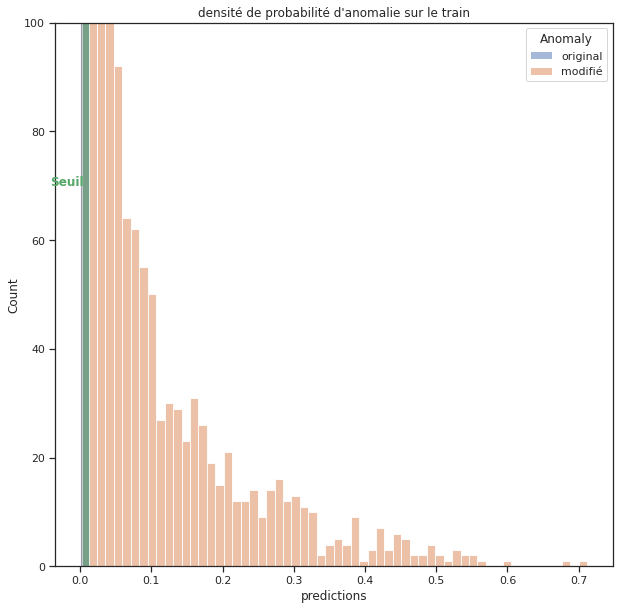

In [ ]:
#on cherche à visualiser l'évolution de la catégorisation en anomalie sur les fichiers modifiés ou non pour définir un seuil de détection optimal

robustesse=0.9

y_qualif_sorted=np.sort(y_qualif_OK[:,y_qualif_OK.shape[1]-1])
seuil_anorm=y_qualif_sorted[int(y_qualif_sorted.shape[0]*robustesse)]

plt.figure(figsize=(10,10))
sns.catplot(x="cols", y="vals", hue="Anomaly",alpha=0.5, split=True, data=data_graph.melt("Anomaly", var_name="cols",  value_name="vals"))
plt.title("densité de probabilité par ID sur le train")
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Predic_train'+machine+'.jpg' )

plt.figure(figsize=(10,10))
sns.histplot(data=data_graph, x='predictions',hue="Anomaly",bins=int(data_graph.shape[0]/100))

plt.axvspan(max(seuil_anorm-0.005,0),seuil_anorm+0.005, facecolor='g', alpha=0.5)
plt.ylim((0,100))
plt.text((seuil_anorm-0.05),70,'Seuil',color='g',fontsize='medium',fontweight='bold')

plt.title("densité de probabilité d'anomalie sur le train");
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Anomaly_train'+machine+'.jpg' )

,ID_1,ID_2,ID_3,Anomaly
0,0.0,0.980246,0.0,0.000000
1,0.0,0.995537,0.0,0.000000
2,0.0,0.985119,0.0,0.000000
3,0.0,0.991521,0.0,0.000000
4,0.0,0.979068,0.0,0.000000
...,...,...,...,...
3504,0.0,0.982895,0.0,0.000378
3505,0.0,0.996706,0.0,0.000069
3506,0.0,0.985860,0.0,0.000325
3507,0.0,0.993972,0.0,0.000100


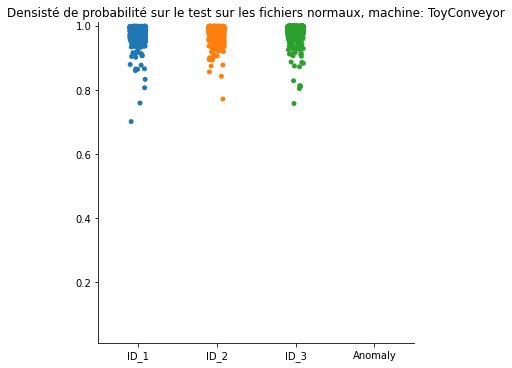

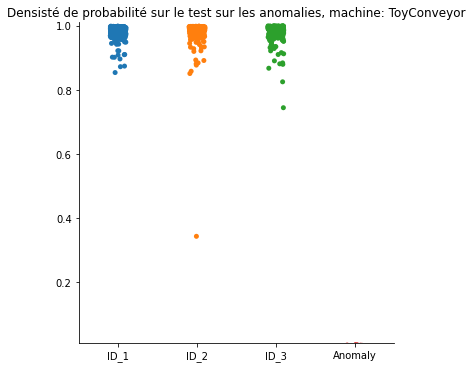

In [71]:
#Réalisation des densités de probabilité sur le test
y_test_multi=y_test_ID_dum.replace([1-coef_anorm,coef_anorm],[1,1])

y_pred_test[y_test_multi.Anomaly==0]=y_pred_test[y_test_multi.Anomaly==0]*y_test_multi[y_test_multi.Anomaly==0]
y_pred_test[y_test_multi.Anomaly>0]=y_pred_test[y_test_multi.Anomaly>0]*y_test_multi[y_test_multi.Anomaly>0]

y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test.columns=y_test_multi.columns

sns.catplot(data=y_pred_test[y_pred_test.Anomaly==0])
plt.title("Densisté de probabilité sur le test sur les fichiers normaux, machine: "+ machine)
plt.ylim((0.01,1.01));
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Predic_test_norm'+machine+'.jpg' )

sns.catplot(data=y_pred_test[y_pred_test.Anomaly>0])
plt.title("Densisté de probabilité sur le test sur les anomalies, machine: "+ machine)
plt.ylim((0.01,1.01));
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Proba_Predic_test_anorm'+machine+'.jpg' )

score AUC 58.42 %


<Figure size 720x720 with 0 Axes>

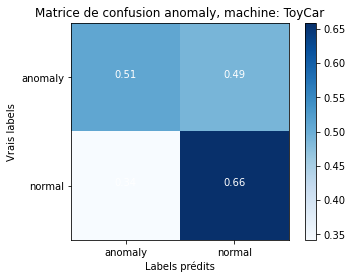

In [ ]:
#seuil par ID
seuil_ID=np.array([0.5,0.3,0.3,0.9,0.2])
classes=['anomaly','normal']
y_seuil=y_test_multi*seuil_ID
y_desc=np.array(y_pred_test-y_seuil).sum(axis=1)
y_desc=np.where(y_desc<0,'anomaly','normal')


#calcul de l'AUC
fpr, tpr, thresholds = metrics.roc_curve(pd.DataFrame(y_test_son).replace(['normal','anomaly'],[normal_val,anomaly_val]), pd.DataFrame(y_desc).replace(['normal','anomaly'],[normal_val,anomaly_val]))
print('score AUC {:0.2f} %'.format(metrics.auc(fpr, tpr)*100))
#affichage de la crosstab
crosstab=pd.crosstab(y_test_son, y_desc, rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion anomaly, machine: "+ machine)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(np.array(crosstab)[i, j],2),
             horizontalalignment="center",
             color="white" if np.array(crosstab)[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Matrice_Confusion_'+machine+'.jpg' )

score AUC 99.67 %


<Figure size 720x720 with 0 Axes>

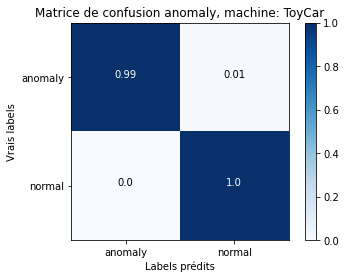

In [ ]:
#seuil sur anomaly
seuil_anorm=0.0000001
classes=['anomaly','normal']
y_desc=np.where(y_pred_test.Anomaly>seuil_anorm,'anomaly','normal')

#calcul de l'AUC
fpr, tpr, thresholds = metrics.roc_curve(pd.DataFrame(y_test_son).replace(['normal','anomaly'],[normal_val,anomaly_val]), pd.DataFrame(y_desc).replace(['normal','anomaly'],[normal_val,anomaly_val]))
print('score AUC {:0.2f} %'.format(metrics.auc(fpr, tpr)*100))
#affichage de la crosstab
crosstab=pd.crosstab(y_test_son, y_desc, rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion anomaly, machine: "+ machine)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(np.array(crosstab)[i, j],2),
             horizontalalignment="center",
             color="white" if np.array(crosstab)[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Matrice_Confusion_'+machine+'.jpg' )

In [ ]:
#seuil sur anomaly
y_qualif_sorted=np.sort(y_qualif[:,y_qualif.shape[1]-1])
robustesse=0.5
seuil_anorm=y_qualif_sorted[int(y_qualif_sorted.shape[0]*robustesse)]

classes=['anomaly','normal']
y_desc_train=np.where(y_pred_train.Anomaly>seuil_anorm,'anomaly','normal')
y_desc_test=np.where(y_pred_test.Anomaly>seuil_anorm,'anomaly','normal')


#calcul de l'AUC
fpr, tpr, thresholds = metrics.roc_curve(np.zeros(y_train_ID_dum.shape[0]), pd.DataFrame(y_desc_train).replace(['normal','anomaly'],[normal_val,anomaly_val]))
print('score AUC test {:0.2f} %'.format(metrics.auc(fpr, tpr)*100))
#affichage de la crosstab
crosstab=pd.crosstab(pd.DataFrame(np.zeros(y_train_ID_dum.shape[0])), pd.DataFrame(y_desc_train).replace(['normal','anomaly'],[normal_val,anomaly_val]), rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion sur train, machine: "+ machine)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(np.array(crosstab)[i, j],2),
             horizontalalignment="center",
             color="white" if np.array(crosstab)[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Matrice_Confusion_'+machine+'.jpg' )




#calcul de l'AUC
fpr, tpr, thresholds = metrics.roc_curve(pd.DataFrame(y_test_son).replace(['normal','anomaly'],[normal_val,anomaly_val]), pd.DataFrame(y_desc_test).replace(['normal','anomaly'],[normal_val,anomaly_val]))
print('score AUC test {:0.2f} %'.format(metrics.auc(fpr, tpr)*100))
#affichage de la crosstab
crosstab=pd.crosstab(y_test_son, y_desc_test, rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion sur test, machine: "+ machine)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(np.array(crosstab)[i, j],2),
             horizontalalignment="center",
             color="white" if np.array(crosstab)[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');
plt.savefig('/content/drive/MyDrive/Datascience projet son/Corentin/plot/Matrice_Confusion_'+machine+'.jpg' )

score AUC test nan %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TypeError: ignored